### **Overview**

This notebooks is designed to explore initial usage of the JSON file that contains metadata about notes in the Data Archive. 

1. **Data Loading**: Load the JSON file containing metadata about notes in the Data Archive.
2. **Data Exploration**: Explore the structure and contents of the JSON file to understand the relationships between notes.
3. **Data Analysis and Visualization**: Analyze the relationships between notes and their centrality within the vault.


### TOC

- [1. Data Loading](#1-data-loading)
- [2. Data Exploration](#2-data-exploration)    
- [3. Data Analysis and Visualization](#3-data-analysis-and-visualization)

### **1. Data Loading**

In [2]:
import json
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx


In [3]:
# Load the vault index
with open("../Data/enhanced_vault_index.json", "r", encoding="utf-8") as f:
    vault = json.load(f)

### 2. Data Exploration

#### Vault_index

In [4]:
print(f"Loaded {len(vault)} notes from vault_index.json")
# Preview a few entries
for i, (k, v) in enumerate(vault.items()):
    print(f"{k}: {list(v.keys())}")
    if i == 1: break

Loaded 796 notes from vault_index.json
1-on-1_template: ['title', 'tags', 'aliases', 'outlinks', 'inlinks', 'summary', 'TFIDF_Score']
ab_testing: ['title', 'tags', 'aliases', 'outlinks', 'inlinks', 'summary', 'TFIDF_Score']


In [19]:
# id="views"
# vault[id]
# based on the views subg below database_schema references itself in the outlinks/inlinks
vault['database_schema']

{'title': 'Database Schema',
 'tags': ['data_modeling', 'database_structure'],
 'aliases': ['schema', 'Schema'],
 'outlinks': ['conceptual_data_model',
  'data_modelling',
  'data_management',
  'database',
  'implementing_database_schema',
  'types_of_database_schema',
  'database_schema'],
 'inlinks': ['soft_deletion',
  'structured_data',
  'database',
  'views',
  'data_lakehouse',
  'schema_evolution',
  'database_schema',
  'fact_table'],
 'summary': 'A [[Database Schema|schema]] is the structure that defines how data is organized in a [[Database]], used in [[Data Management]]. It specifies the tables, columns, relationships,...',
 'TFIDF_Score': {'schema': 0.7443321263000408,
  'database': 0.2553458164023245,
  'data': 0.25479508536284223,
  'read': 0.1604570921297529,
  'structure': 0.14471264583778357,
  'design': 0.10912213859569721,
  'strategic': 0.10334085623681936,
  'table': 0.08994025858153504,
  'iterative': 0.0883799489013294,
  'write': 0.08385766781333415}}

In [6]:
first_note = list(vault.values())[0]
first_note

{'title': '1-on-1 Template',
 'tags': [],
 'aliases': [],
 'outlinks': [],
 'inlinks': ['documentation_&_meetings'],
 'summary': "Decisions [Your name] add decisions that need to be made [Other person's name] add decisions that need to be made Action items [Your name] add...",
 'TFIDF_Score': {'add': 0.4711112048057346,
  'name': 0.44147266637033267,
  'person': 0.3754032147055681,
  'discus': 0.28155241102917605,
  'action': 0.25508518127200086,
  'topic': 0.20691725714571982,
  'directional': 0.20349409769691357,
  'needed': 0.1926581374212508,
  'discussion': 0.17317115423681162,
  'update': 0.1647981937876021}}

#### Tags

In [7]:
# Initialize an empty dictionary to store tag counts
tag_counts = {}

# Safeguard against invalid notes in the vault (None or non-dictionary values)
for note in vault.values():
    if isinstance(note, dict):  # Ensure note is a valid dictionary
        tags = note.get("tags", [])  # Safely get 'tags', default to empty list if none
        if isinstance(tags, list):  # Ensure tags is a list
            for tag in tags:
                if isinstance(tag, str):  # Ensure tag is a valid string
                    tag_counts[tag] = tag_counts.get(tag, 0) + 1  # Increment the count for the tag

# Sort the tags by frequency in descending order
sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 most common tags
print("\nTop 10 Tags:")
for tag, count in sorted_tags[:10]:
    print(f"{tag}: {count}")



Top 10 Tags:
software: 47
database: 23
data_transformation: 23
data_storage: 21
drafting: 20
evaluation: 19
statistics: 19
#question: 17
data_orchestration: 15
deep_learning: 14


#### Orphan notes

In [8]:
orphans = [
    title for title, note in vault.items()
    if not note.get("outlinks", []) and all(title not in n.get("outlinks", []) for n in vault.values())
]
print(f"\nNumber of orphan notes: {len(orphans)}")



Number of orphan notes: 52


#### Directed Link Graph

In [9]:
G = nx.DiGraph()

# Add nodes and edges (ensure we fetch outlinks and other necessary attributes correctly)
for title, note in vault.items():
    G.add_node(title)  # No tags added since not directly available in the note dictionary
    outlinks = note.get("outlinks", [])  # Fetch outlinks from an external source if not in the note dictionary
    for outlink in outlinks:
        if outlink in vault:  # Only add edge if target exists
            G.add_edge(title, outlink)

print(f"\nGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph has 796 nodes and 2159 edges


### 3. Data Analysis and Visualization

#### Subgraphs

In [ ]:
def plot_graph(graph, figsize=(8, 6), label_nodes=False,center_title="",font_size=14, k=0.1):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(graph, k=k, seed=42)  # Reduced k for shorter edges
    nx.draw(graph, pos, node_size=80, edge_color='gray', alpha=0.6)
    if label_nodes:
        nx.draw_networkx_labels(graph, pos, font_size=font_size)  # Increased font_size here
    plt.title(f'1-hop Neighborhood of: {center_title}')
    plt.axis('off')
    plt.show()

def get_subgraph(center_title, depth=1, remove_loops=False):
    if center_title not in G:
        print(f"'{center_title}' not found in graph.")
        return None
    
    # Generate ego graph
    sub = nx.ego_graph(G, center_title, radius=depth)
    # Remove self-loops
    if remove_loops:
        # Remove self-loops from the subgraph
        self_loops = list(nx.selfloop_edges(sub))
        sub.remove_edges_from(self_loops)
    
    print(f"Subgraph has {len(sub)} nodes and {sub.number_of_edges()} edges")
    return sub


Subgraph has 7 nodes and 11 edges


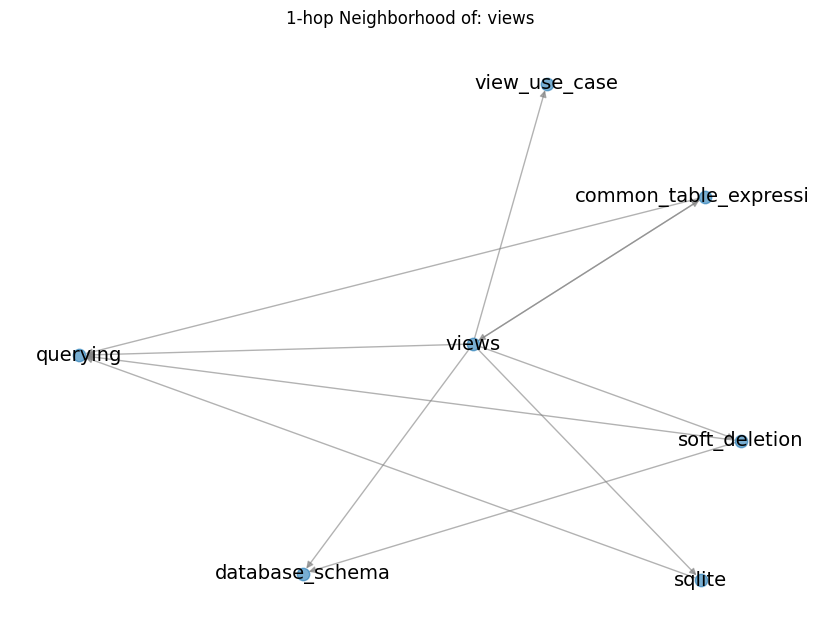

In [25]:
# Example: a 1-hop neighborhood
subG = get_subgraph("views", depth=1,remove_loops=True)
subG = get_subgraph("views", depth=1)
plot_graph(subG, label_nodes=True,center_title="views", font_size=14, k=2)  # Font size set to 14 and reduced edge length with k=0.1

#### Rank Notes by Centrality

In [26]:
centrality = nx.degree_centrality(subG)
top_nodes = sorted(centrality.items(), key=lambda x: -x[1])[:10]
print("\nTop 10 central notes:")
for t, score in top_nodes:
    print(f"{t}: {score:.3f}")


Top 10 central notes:
views: 1.167
querying: 0.667
soft_deletion: 0.500
common_table_expression: 0.500
database_schema: 0.333
sqlite: 0.333
view_use_case: 0.167
